## Content

[1. Import libraries](#Import_libraries)<br>
[2. Import data](#Import_data)<br>
[3.Data cleaning](#Data_cleaning)<br>
[- Split data in "auto_engine" into 3 columns](#Split_auto_engine)<br>
[- Formating columns (Dtype, creating new columns, etc.)](#Formating_columns)<br>
[4. Exploratory data analysis](#Exploratory_data_analysis)<br>
[5. Encoding categorical values](#Encoding_categorical_values)<br>
[6. Checking correlations between features](#Checking_correlations_between_features)<br>
[7. Splitting our data into Training and Testing data](#Splitting_our_data_into_Training_and_Testing_data)<br>
[8. Linear Regression](#Linear_Regression)<br>
[9. Random Forest](#Random_Forest)<br>
[11. GradientBoostingRegressor](#GradientBoostingRegressor)<br>
[12. LightGBM](#LightGBM)<br>
[13. CatBoostRegressor](#CatBoostRegressor)<br>
[14. XGboost](#XGboost)<br>
[15. Model Analysis](#Model_Analysis)<br>
[16. Saving model](#Saving_model)<br>

<a id='Import_libraries'></a>
<h2>Import libraries</h2>

In [108]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

<a id='Import_data'></a>
## Import data

In [109]:
data = pd.read_csv("../data/auto_data.csv", sep=';')
data.shape

(2518, 13)

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Type               2518 non-null   object
 1   auto_price         2518 non-null   object
 2   auto_year          2518 non-null   int64 
 3   auto_owners        2518 non-null   object
 4   auto_guarantee     2266 non-null   object
 5   auto_mileage       2518 non-null   object
 6   auto_engine        2518 non-null   object
 7   auto_transmission  2518 non-null   object
 8   auto_drive_unit    2518 non-null   object
 9   auto_wheel         2518 non-null   object
 10  auto_carcase       2518 non-null   object
 11  auto_color         2511 non-null   object
 12  link               2518 non-null   object
dtypes: int64(1), object(12)
memory usage: 255.9+ KB


There are also some empty cells in 'auto_color' and 'auto_guarantee' columns.
Empty 'auto_guarantee' column means that car doesn't have guarantee.
We will fill empty 'auto_guarantee' cells wit zeros.
Empty 'auto_color' cells will be filled with the most popular color.

<a id='Data_cleaning'></a>
## Data cleaning

<a id="Split_auto_engine"></a>
### Split data in "auto_engine" into 3 columns

In [111]:
data[['Engine_displacement', 'Capacity', 'Fuel']] = data['auto_engine'].str.split(pat='/\n', expand=True)

<a id="Formating_columns"></a>
### Formating columns (Dtype, creating new columns, etc.)

In [112]:
#Formating column with price
data[['Price', 'Currency']] = data.auto_price.str.split(pat='                    ', expand=True)
data.Price = data.Price.str.replace(' ', '')
data = data.astype({'Price': 'int64'})

#Formating column Engine_displacement
data.Engine_displacement = data.Engine_displacement.apply(str).str.replace(' л ', '')
data = data.astype({'Engine_displacement': 'float64'})

#Formating column Capacity
data.Capacity = data.Capacity.apply(str).str.replace(' л.с.', '')
data = data.astype({'Capacity': 'int64'})

#Formating column owners
data[['owners', '1']] = data['auto_owners'].apply(str).str.split(pat="                ", expand=True)
data = data.drop(['1'], axis=1)
data['owners'] = [x for x in data['owners']]
data = data.astype({'owners':'int64'})

#Formating column auto_mileage
data['auto_mileage'] = data['auto_mileage'].apply(str).str.replace(' км', '')
data['auto_mileage'] = data['auto_mileage'].apply(str).str.replace(' ', '')
data['auto_mileage'] = data['auto_mileage'].astype('int64')

#Creating columns with brand and model
data[['htpp', 'emp', 'web', 'city', 'type', 'brand', 'model', 'id', 'em2']] = data['link'].str.split(pat='/', expand=True)

data['brand_model'] = data['brand'] + "_" + data['model']
#df.apply(lambda row: fuzz.ratio(row['name'], row['name_2']), axis = 1)

In [113]:
data = data.drop(columns=['htpp', 'emp', 'web', 'city', 'type', 'em2',
                          'auto_price', 'auto_owners', 'auto_engine', 'Currency'])

In [114]:
data[['emp','guarantee_date']] = data['auto_guarantee'].str.split(pat='                  ', expand=True)
data[['guarantee_month', 'guarantee_year']] = data['guarantee_date'].str.split(pat='.', expand=True)
data['guarantee_year'] = [0 if x is None else x for x in data['guarantee_year']]
data['guarantee_month'] = [0 if x is None else x for x in data['guarantee_month']]

data.guarantee_month = data.guarantee_month.fillna(0)
data.guarantee_year = data.guarantee_year.fillna(0)
data.guarantee_date = data.guarantee_date.fillna(0)
data.guarantee_year = data.guarantee_year.astype(np.float).astype("int64")
data.guarantee_month = data.guarantee_month.astype(np.float).astype("int64")
data.guarantee_date = data.guarantee_date.astype(np.float).astype("int64")
data.auto_year = data.auto_year.astype(np.float).astype("int64")
#data = data.astype({'guarantee_year': 'int64', 'guarantee_month':'int64', 'auto_year': 'int64'})

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 2518 non-null   object 
 1   auto_year            2518 non-null   int64  
 2   auto_guarantee       2266 non-null   object 
 3   auto_mileage         2518 non-null   int64  
 4   auto_transmission    2518 non-null   object 
 5   auto_drive_unit      2518 non-null   object 
 6   auto_wheel           2518 non-null   object 
 7   auto_carcase         2518 non-null   object 
 8   auto_color           2511 non-null   object 
 9   link                 2518 non-null   object 
 10  Engine_displacement  2518 non-null   float64
 11  Capacity             2518 non-null   int64  
 12  Fuel                 2518 non-null   object 
 13  Price                2518 non-null   int64  
 14  owners               2518 non-null   int64  
 15  brand                2518 non-null   o

<a id="Exploratory_data_analysis"></a>
## Exploratory data analysis 

In [116]:
pd.options.display.float_format = '{:,.0f}'.format

data.Price.describe()

count        2,518
mean     2,099,148
std      1,949,885
min         97,200
25%      1,039,000
50%      1,598,283
75%      2,469,947
max     23,996,000
Name: Price, dtype: float64

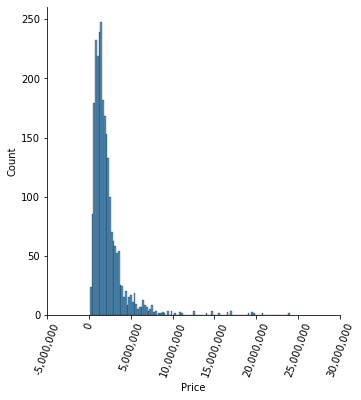

In [117]:
fig1 = sns.displot(data=data, x='Price')
ticks = fig1.axes[0][0].get_xticks()
xlabels = ['{:,.0f}'.format(x) for x in ticks]
fig1.set_xticklabels(xlabels, rotation=70)

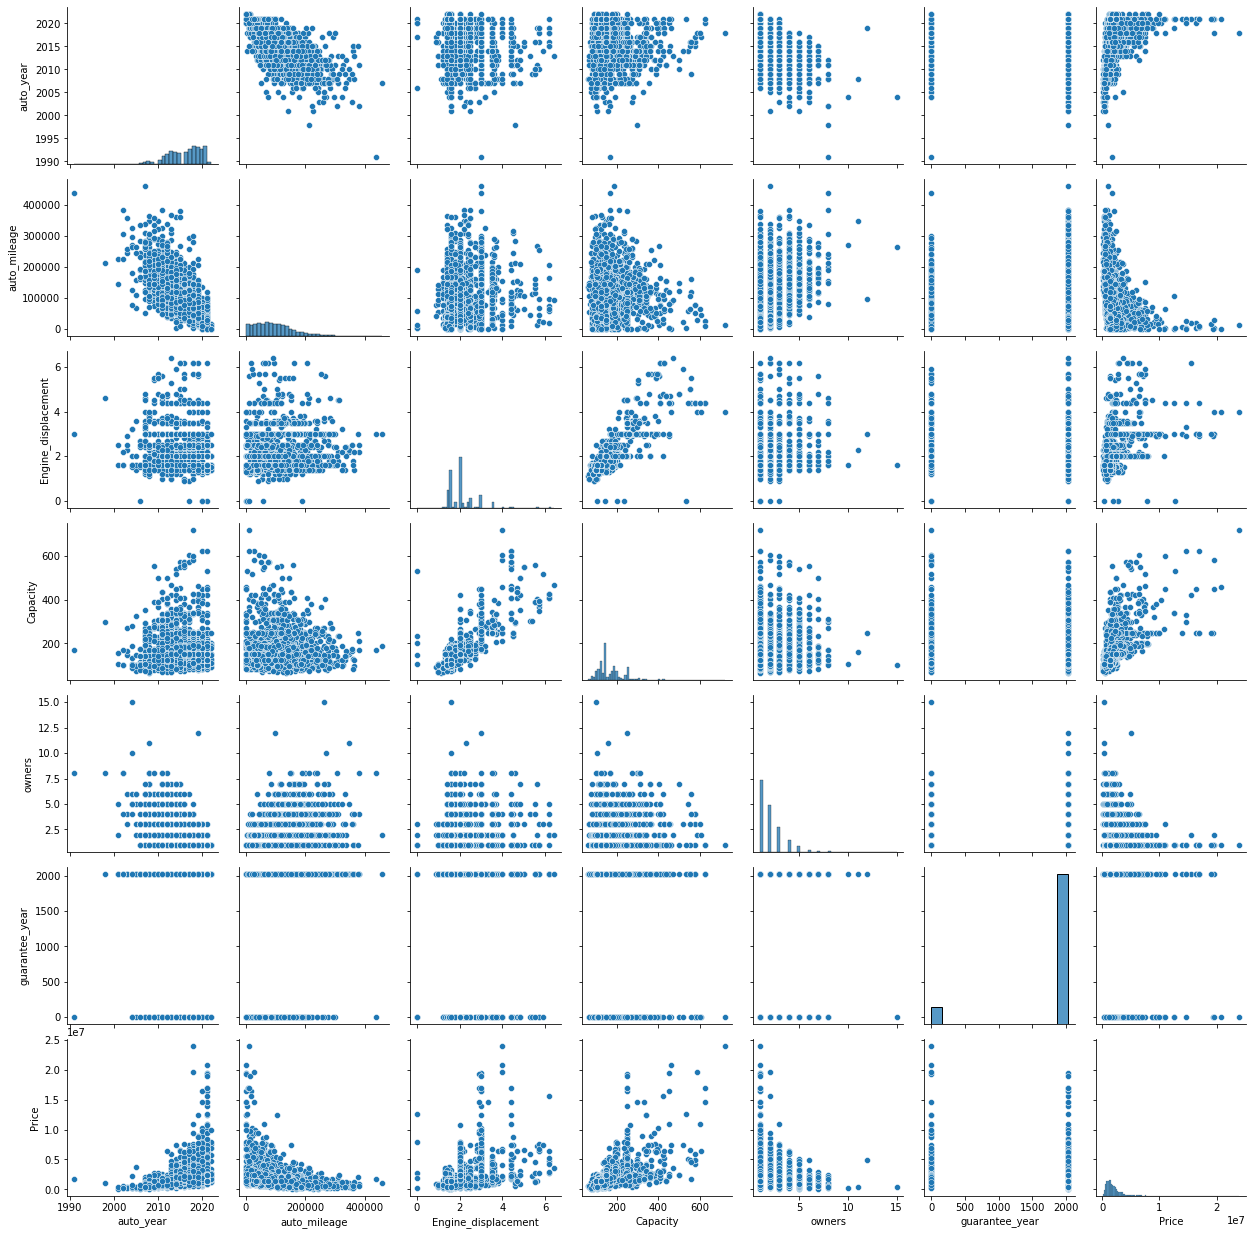

In [118]:
features = ['auto_year', 'auto_mileage', 'Engine_displacement', 'Capacity', 'owners', 'guarantee_year', 'Price']
g = sns.PairGrid(data[features])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

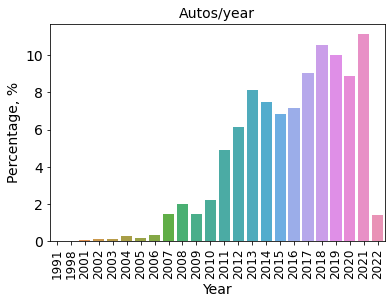

In [119]:
auto_year_val = (data['auto_year'].value_counts(normalize=True).mul(100).rename('Percent').reset_index())
sns.barplot(x='index', y='Percent', data=auto_year_val)
plt.title('Autos/year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage, %', fontsize=14)

plt.xticks(fontsize=12, rotation='vertical')
plt.yticks(fontsize=14)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

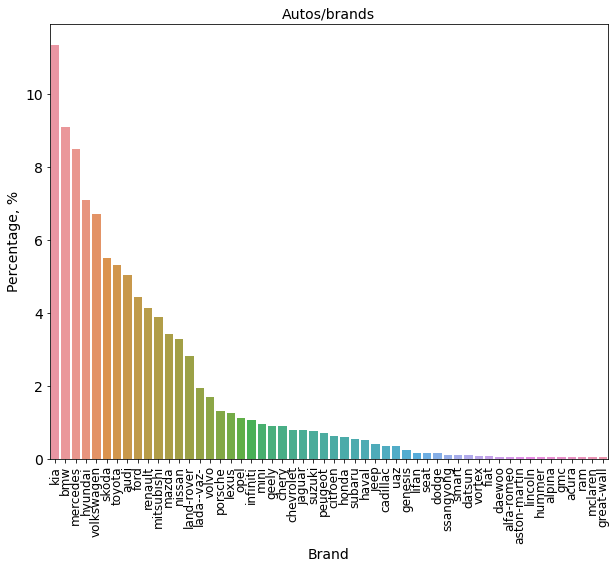

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
auto_brand = (data['brand'].value_counts(normalize=True).mul(100).rename('Percent').reset_index())
sns.barplot(ax=ax, x='index', y='Percent', data=auto_brand)
plt.title('Autos/brands', fontsize=14)
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Percentage, %', fontsize=14)

plt.xticks(fontsize=12, rotation='vertical')
plt.yticks(fontsize=14)
#auto_brand.sort_values(by='Percent', ascending=False)

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

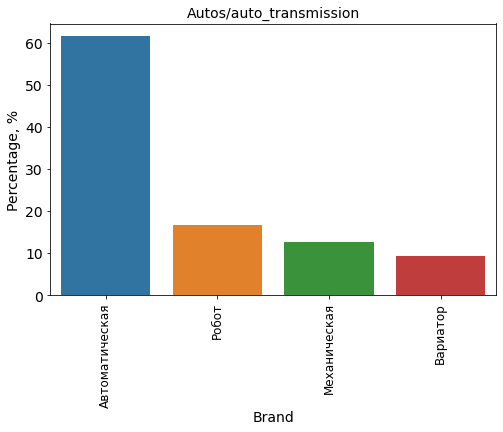

In [121]:
fig, ax = plt.subplots(figsize=(8, 5))
auto_brand = (data['auto_transmission'].value_counts(normalize=True).mul(100).rename('Percent').reset_index())
sns.barplot(ax=ax, x='index', y='Percent', data=auto_brand)
plt.title('Autos/auto_transmission', fontsize=14)
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Percentage, %', fontsize=14)

plt.xticks(fontsize=12, rotation='vertical')
plt.yticks(fontsize=14)


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

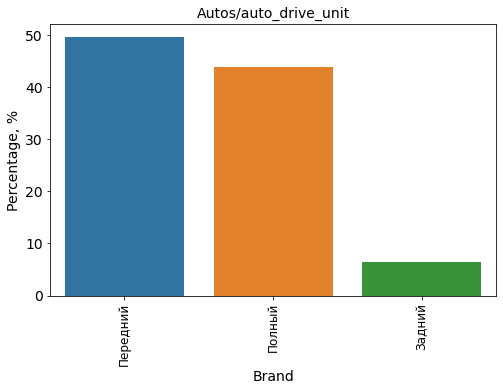

In [122]:
fig, ax = plt.subplots(figsize=(8, 5))
auto_brand = (data['auto_drive_unit'].value_counts(normalize=True).mul(100).rename('Percent').reset_index())
sns.barplot(ax=ax, x='index', y='Percent', data=auto_brand)
plt.title('Autos/auto_drive_unit', fontsize=14)
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Percentage, %', fontsize=14)

plt.xticks(fontsize=12, rotation='vertical')
plt.yticks(fontsize=14)


<a id="Encoding_categorical_values"></a>
## Encoding categorical values

Some columns (auto_carcase, auto_drive_unit, transmission, auto_brand, auto_model) contain categorical values.<br/>
Let's encode them so we can see correlation b/w those columns and Price colimn.

In [123]:
data['carcase'] = 0
SUV = ['Внедорожник 3 дв.', 'Внедорожник 3 дв. Urban', 'Внедорожник 5 дв.', 'Внедорожник 5 дв. Cooper S',
       'Внедорожник 5 дв. Coupe', 'Внедорожник 5 дв. Grand', 'Внедорожник 5 дв. JCW', 'Внедорожник 5 дв. L',
       'Внедорожник 5 дв. Long', 'Внедорожник 5 дв. Prime', 'Внедорожник 5 дв. SRT']

sedan = ['Седан', 'Седан Gran Coupe', 'Седан Long', 'Седан Sport', 'Седан Stepway']

hatchback = ['Хэтчбек 3 дв.', 'Хэтчбек 3 дв. GTC', 'Хэтчбек 3 дв. JCW', 'Хэтчбек 5 дв.',
             'Хэтчбек 5 дв. Cooper S', 'Хэтчбек 5 дв. Cross', 'Хэтчбек 5 дв. Sportback',
             'Хэтчбек 5 дв. Stepway', 'Хэтчбек 5 дв. X', 'Хэтчбек 5 дв. X-Line']

liftback = ['Лифтбек', 'Лифтбек Gran Coupe', 'Лифтбек Gran Turismo', 'Лифтбек Sportback']

station_wagon = ['Универсал 5 дв.', 'Универсал 5 дв. All-Terrain', 'Универсал 5 дв. SW', 'Универсал 5 дв. SW Cross',
                 'Универсал 5 дв. Scout', 'Универсал 5 дв. Cross']

minivan = ['Компактвэн', 'Компактвэн Freetrack', 'Компактвэн Grand', 'Компактвэн Life',
           'Минивэн L', 'Минивэн L2', 'Минивэн', 'Минивэн LWB', 'Минивэн M', 'Минивэн SWB']

In [124]:
def carcase_type(data):
    data['carcase'] = data.auto_carcase.apply(lambda x : 'SUV' if x in SUV
                                              else 'sedan' if x in sedan
                                              else 'hatchback' if x in hatchback
                                              else 'liftback' if x in liftback
                                              else 'station_wagon' if x in station_wagon
                                              else 'minivan' if x in minivan
                                              else 'other')

In [125]:
carcase_type(data)

In [126]:
data.groupby(['carcase'])['carcase'].count()

carcase
SUV              1144
hatchback         270
liftback          152
minivan            54
other              78
sedan             737
station_wagon      83
Name: carcase, dtype: int64

In [127]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [128]:
ord_enc = OrdinalEncoder()
data["auto_carcase_enc"] = ord_enc.fit_transform(data[["carcase"]])
data["auto_brand_enc"] = ord_enc.fit_transform(data[["brand"]])
data["auto_model_enc"] = ord_enc.fit_transform(data[["model"]])
data["auto_transmission_enc"] = ord_enc.fit_transform(data[["auto_transmission"]])
data["auto_drive_unit_enc"] = ord_enc.fit_transform(data[["auto_drive_unit"]])

In [129]:
#data["drive_unit_enc"] = ord_enc.fit_transform(data[["auto_drive_unit"]])
#data["transmission_enc"] = ord_enc.fit_transform(data[["auto_transmission"]])
drive_unit_enc = pd.get_dummies(data["auto_drive_unit"])
drive_unit_enc.columns = ['back_drive_unit', 'front_drive_unit', 'full_drive_unit']

In [130]:
transmission_enc = pd.get_dummies(data["auto_transmission"])
transmission_enc.columns = ['auto_transmission', 'var_transmission', 'mech_transmission', 'rob_transmission']

In [131]:
data[['back_drive_unit', 'front_drive_unit', 'full_drive_unit']] = drive_unit_enc
data[['a_transmission', 'var_transmission', 'mech_transmission', 'rob_transmission']] = transmission_enc

In [132]:
data_country = pd.read_csv('../data/brand_country.csv', sep=';')

In [133]:
data = data.join(data_country.set_index('brand'), on='brand')

In [134]:
data["auto_country"] = ord_enc.fit_transform(data[["Country"]])

In [135]:
data["km/year"] = data.auto_mileage / (data.auto_year + 1)

In [136]:
(data[data['Price'] < 6000000].Price.count()) / data.Price.count()

0.9650793650793651

In [137]:
(data.Price.count() - data[data['Price'] < 400000].Price.count() - data[data['Price'] > 6000000].Price.count()) / data.Price.count()

0.946031746031746

In [138]:
data = data.drop(data[data['Price'] > 6000000].index, axis=0)
data = data.drop(data[data['Price'] < 400000].index, axis=0)

In [139]:
pd.options.display.float_format = '{:,.0f}'.format

data.Price.describe()

count       2,384
mean    1,862,896
std     1,108,161
min       400,000
25%     1,049,000
50%     1,576,749
75%     2,350,138
max     6,000,000
Name: Price, dtype: float64

<a id="Checking_correlations_between_features"></a>
## Checking correlations between features

In [140]:
features = ['Price', 'auto_year', 'auto_guarantee', 'auto_mileage',
            'Engine_displacement', 'Capacity', 'Fuel', 'owners',
            'guarantee_year', 'auto_carcase_enc', 'auto_brand_enc', 
            'auto_model_enc', 'auto_transmission_enc', 'auto_drive_unit_enc', 
            'back_drive_unit', 'front_drive_unit', 'full_drive_unit', 
            'a_transmission', 'var_transmission', 'mech_transmission', 
            'rob_transmission', 'auto_country', 'km/year']

data_corr = data[features]
corr = data_corr.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Price,auto_year,auto_mileage,Engine_displacement,Capacity,owners,guarantee_year,auto_carcase_enc,auto_brand_enc,auto_model_enc,auto_transmission_enc,auto_drive_unit_enc,back_drive_unit,front_drive_unit,full_drive_unit,a_transmission,var_transmission,mech_transmission,rob_transmission,auto_country,km/year
Price,1.00,0.45,-0.41,0.38,0.54,-0.14,-0.09,-0.14,-0.12,0.02,-0.18,0.36,0.02,-0.46,0.45,0.24,-0.07,-0.31,0.01,-0.04,-0.41
auto_year,0.45,1.00,-0.75,-0.24,-0.15,-0.54,0.07,0.05,0.02,0.11,0.01,-0.02,-0.12,0.15,-0.09,0.01,-0.00,-0.06,0.04,-0.08,-0.75
auto_mileage,-0.41,-0.75,1.00,0.20,0.10,0.45,-0.04,0.01,-0.01,-0.05,-0.01,0.03,0.08,-0.11,0.08,-0.00,-0.02,0.09,-0.05,0.08,1.00
Engine_displacement,0.38,-0.24,0.20,1.00,0.81,0.24,-0.08,-0.12,-0.10,0.02,-0.34,0.37,0.02,-0.47,0.47,0.34,-0.05,-0.21,-0.22,0.18,0.20
Capacity,0.54,-0.15,0.10,0.81,1.00,0.28,-0.15,-0.08,-0.23,-0.04,-0.22,0.38,0.08,-0.55,0.51,0.29,-0.10,-0.32,-0.02,0.03,0.10
owners,-0.14,-0.54,0.45,0.24,0.28,1.00,-0.05,0.06,-0.11,-0.16,-0.04,-0.00,0.18,-0.17,0.09,0.07,-0.07,-0.07,0.02,0.02,0.45
guarantee_year,-0.09,0.07,-0.04,-0.08,-0.15,-0.05,1.00,-0.06,0.06,0.03,0.01,0.02,-0.07,0.05,-0.01,-0.03,0.03,0.01,0.00,-0.01,-0.04
auto_carcase_enc,-0.14,0.05,0.01,-0.12,-0.08,0.06,-0.06,1.00,-0.10,-0.32,-0.03,-0.48,0.25,0.34,-0.46,0.10,-0.21,0.06,-0.02,0.04,0.01
auto_brand_enc,-0.12,0.02,-0.01,-0.10,-0.23,-0.11,0.06,-0.10,1.00,0.23,0.11,0.01,-0.18,0.17,-0.08,-0.17,0.14,0.14,-0.00,-0.16,-0.01
auto_model_enc,0.02,0.11,-0.05,0.02,-0.04,-0.16,0.03,-0.32,0.23,1.00,0.00,0.20,-0.23,-0.01,0.13,-0.06,0.11,0.05,-0.05,0.10,-0.05


High correlation b/t features: <br/>
    1) auto_year, auto_mileage, owners. Corr b/w auto_year&Price is the higest <br/>
    2) Capacity, Engine_displacement. Corr b/w Capacity&Price is higher	<br/>
    Let's drop the following features: ['auto_mileage', 'owners', 'Engine_displacement', 'auto_model', 'auto_country']

In [141]:
data_corr = data_corr[['Price', 'auto_year', 'Capacity', 'guarantee_year', 'auto_carcase_enc',
                       'auto_brand_enc', 'auto_transmission_enc', 'auto_drive_unit_enc']]

In [142]:
corr = data_corr.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Price,auto_year,Capacity,guarantee_year,auto_carcase_enc,auto_brand_enc,auto_transmission_enc,auto_drive_unit_enc
Price,1.00,0.45,0.54,-0.09,-0.14,-0.12,-0.18,0.36
auto_year,0.45,1.00,-0.15,0.07,0.05,0.02,0.01,-0.02
Capacity,0.54,-0.15,1.00,-0.15,-0.08,-0.23,-0.22,0.38
guarantee_year,-0.09,0.07,-0.15,1.00,-0.06,0.06,0.01,0.02
auto_carcase_enc,-0.14,0.05,-0.08,-0.06,1.00,-0.10,-0.03,-0.48
auto_brand_enc,-0.12,0.02,-0.23,0.06,-0.10,1.00,0.11,0.01
auto_transmission_enc,-0.18,0.01,-0.22,0.01,-0.03,0.11,1.00,-0.05
auto_drive_unit_enc,0.36,-0.02,0.38,0.02,-0.48,0.01,-0.05,1.00


<a id="Splitting_our_data_into_Training_and_Testing_data"></a>
## Splitting our data into Training and Testing data

In [143]:
y = data_corr['Price']
X = data_corr.drop(columns=['Price'])

In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [145]:
time_fit = []
time_predict = []
r_squared_test_data = []
rmse = []
mae = []
models = ['LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'LightGBM', 'CatBoostRegressor', 'XGboost']

<a id="Linear_Regression"></a>
## Linear Regression

In [146]:
%%time
from sklearn.linear_model import LinearRegression

reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)

Wall time: 8.01 ms


In [147]:
%%time
prediction = reg.predict(X_test).astype('int64')

Wall time: 6 ms


In [148]:
print('linear model coeff (w): {}'
     .format(reg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(reg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(reg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(reg.score(X_test, y_test)))

linear model coeff (w): [ 1.62385239e+05  9.45051372e+03 -1.05041476e+02 -3.00298480e+04
 -1.29707248e+02 -5.07636566e+04  2.51028267e+05]
linear model intercept (b): -327158780.742
R-squared score (training): 0.617
R-squared score (test): 0.600


In [50]:
score = mean_squared_error(y_test, prediction)
lr_rmse = np.sqrt(score)
score_mae = mean_absolute_error(y_test, prediction)
score_mae, lr_rmse

(483183.6855345912, 668781.0272808509)

Just 62% and 60% of data in training and test data respectivly fit our linear model. <br>

In [89]:
time_fit.append(260)
time_predict.append(4)
r_squared_test_data.append(0.600)
rmse.append(lr_rmse)
mae.append(score_mae)

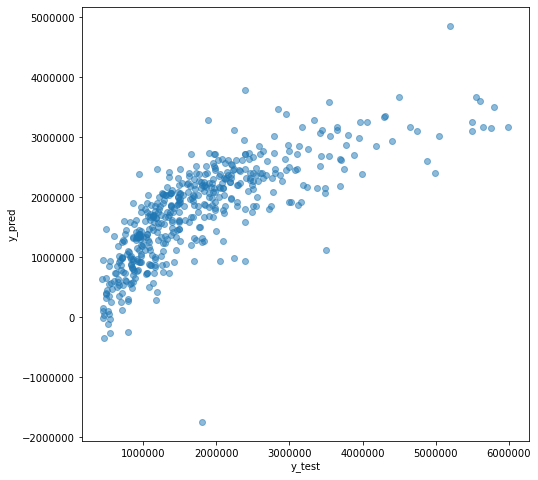

In [52]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.ticklabel_format(style='plain')
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

<a id="Random_Forest"></a>
## Random Forest 

In [53]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)

Wall time: 322 ms


In [54]:
%%time
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1min 35s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [55]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [56]:
%%time
prediction = rf_random.predict(X_test)

Wall time: 341 ms


In [57]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.8630242991881669


In [59]:
score = mean_squared_error(y_test, prediction)
rf_rmse = np.sqrt(score)
rf_mae = mean_absolute_error(y_test, prediction)
rf_mae, rf_rmse

(262736.4336604404, 391237.35669521)

In [90]:
time_fit.append(60000)
time_predict.append(341)
r_squared_test_data.append(0.8630242991881669)
rmse.append(rf_rmse)
mae.append(rf_mae)

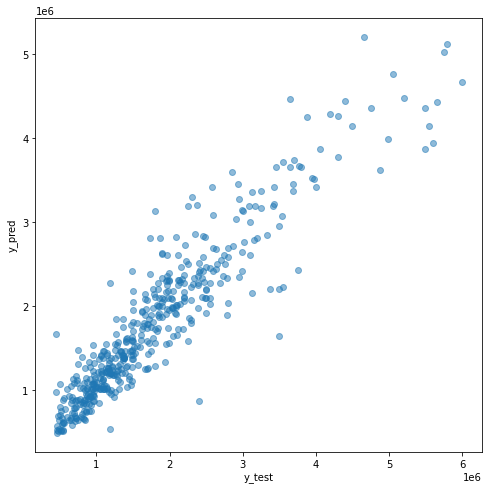

In [61]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

<a id="GradientBoostingRegressor"></a>
## GradientBoostingRegressor

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:
%%time
g_boost = GradientBoostingRegressor(max_depth=10,
                                    n_estimators=70,
                                    learning_rate=0.2,
                                    random_state=42).fit(X_train, y_train)

Wall time: 343 ms


In [64]:
%%time
prediction = g_boost.predict(X_test)

Wall time: 12.1 ms


In [65]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.8425152196690595


In [66]:
score = mean_squared_error(y_test, prediction)
gb_rmse = np.sqrt(score)
gb_mae = mean_absolute_error(y_test, prediction)
gb_mae, gb_rmse

(270654.8589876832, 419505.6795556139)

In [91]:
time_fit.append(343)
time_predict.append(12.1)
r_squared_test_data.append(0.8425152196690595)
rmse.append(gb_rmse)
mae.append(gb_mae)

<a id="LightGBM"></a>
## LightGBM

In [68]:
!pip install lightgbm
import lightgbm

In [69]:
%%time
lgbm_reg = lightgbm.LGBMRegressor(max_depth=10,
                         n_estimators=70,
                         learning_rate=0.2,
                         random_state=42).fit(X_train, y_train)

Wall time: 98 ms


In [70]:
%%time
prediction = lgbm_reg.predict(X_test)

Wall time: 8.01 ms


In [71]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.892064873480946


In [72]:
score = mean_squared_error(y_test, prediction)
lgbm_rmse = np.sqrt(score)
lgbm_mae = mean_absolute_error(y_test, prediction)
lgbm_mae, lgbm_rmse

(243047.57229961632, 347296.1372391959)

In [92]:
time_fit.append(98)
time_predict.append(8.01)
r_squared_test_data.append(0.892064873480946)
rmse.append(lgbm_rmse)
mae.append(lgbm_mae)

<a id="CatBoostRegressor"></a>
## CatBoostRegressor

In [74]:
!pip install catboost
import catboost

In [75]:
%%time
catb = catboost.CatBoostRegressor(max_depth=10,
                                  n_estimators=70,
                                  learning_rate=0.2,
                                  random_state = 42).fit(X_train, y_train)

0:	learn: 994345.3084355	total: 163ms	remaining: 11.3s
1:	learn: 880630.5850894	total: 179ms	remaining: 6.09s
2:	learn: 796465.3319421	total: 196ms	remaining: 4.38s
3:	learn: 724068.6378147	total: 214ms	remaining: 3.54s
4:	learn: 664760.4813767	total: 220ms	remaining: 2.86s
5:	learn: 618290.2831414	total: 237ms	remaining: 2.53s
6:	learn: 578716.4088829	total: 255ms	remaining: 2.29s
7:	learn: 550689.2763866	total: 274ms	remaining: 2.12s
8:	learn: 526194.7189551	total: 290ms	remaining: 1.96s
9:	learn: 503526.3133965	total: 308ms	remaining: 1.85s
10:	learn: 480416.6343590	total: 324ms	remaining: 1.74s
11:	learn: 463206.9657745	total: 339ms	remaining: 1.64s
12:	learn: 448180.9115834	total: 359ms	remaining: 1.57s
13:	learn: 434464.5498040	total: 375ms	remaining: 1.5s
14:	learn: 423251.5492662	total: 393ms	remaining: 1.44s
15:	learn: 413889.7646052	total: 409ms	remaining: 1.38s
16:	learn: 401643.6384642	total: 427ms	remaining: 1.33s
17:	learn: 395530.3779566	total: 446ms	remaining: 1.29s
18:

In [76]:
%%time
prediction = catb.predict(X_test)

Wall time: 4.01 ms


In [77]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.8725831633450192


In [78]:
score = mean_squared_error(y_test, prediction)
cat_rmse = np.sqrt(score)
cat_mae = mean_absolute_error(y_test, prediction)
cat_mae, cat_rmse

(258061.89506505482, 377339.23084591294)

In [93]:
time_fit.append(1024)
time_predict.append(4.01)
r_squared_test_data.append(0.8725831633450192)
rmse.append(cat_rmse)
mae.append(cat_mae)

<a id="XGboost"></a>
## XGboost

In [80]:
!pip install xgboost
import xgboost

In [81]:
%%time
xgb = xgboost.XGBRegressor(max_depth=10,
                               n_estimators=70,
                               random_state = 42).fit(X_train, y_train)

Wall time: 413 ms


In [82]:
%%time 
prediction = xgb.predict(X_test)

Wall time: 10 ms


In [83]:
print('r2 score: ', metrics.r2_score(y_test, prediction))

r2 score:  0.8726296989340934


In [84]:
score = mean_squared_error(y_test, prediction)
xgb_rmse = np.sqrt(score)
xgb_mae = mean_absolute_error(y_test, prediction)
xgb_mae, xgb_rmse

(253666.09361897275, 377270.31802620646)

In [94]:
time_fit.append(413)
time_predict.append(10)
r_squared_test_data.append(0.8726296989340934)
rmse.append(xgb_rmse)
mae.append(xgb_mae)

<a id="Model_Analysis"></a>
# Model Analysis

In [95]:
pd.options.display.float_format
%precision %.3f
pd.set_option("precision", 5)

model_analysis = pd.DataFrame(data = time_fit, index = models, columns=['time_fit'])
model_analysis['time_predict'] = time_predict
model_analysis['r_squared'] = r_squared_test_data
model_analysis['rmse'] = rmse
model_analysis['mae'] = mae

In [96]:
pd.set_option('display.float_format','{:.2f}'.format)

model_analysis = model_analysis.astype({'r_squared': 'float64'})
model_analysis.sort_values(by=['r_squared'])

,time_fit,time_predict,r_squared,rmse,mae
LinearRegression,260,4.00,0.60,668781.03,483183.69
GradientBoostingRegressor,343,12.10,0.84,419505.68,270654.86
RandomForestRegressor,60000,341.00,0.86,391237.36,262736.43
CatBoostRegressor,1024,4.01,0.87,377339.23,258061.90
XGboost,413,10.00,0.87,377270.32,253666.09
LightGBM,98,8.01,0.89,347296.14,243047.57


The fastest model is LightGBM. LightGBM also has pretty high r_squared and relatively low Root Mean Square Error and Mean Absolute Score.<br>
So, let's use LightGBM in our prediction.

<a id="Saving_model"></a>
## Saving and loading object with our model in a file

In [908]:
import pickle
import joblib

joblib.dump(lgbm_reg, "lgb.pkl")

['lgb.pkl']